In [1]:
%matplotlib inline  
from __future__ import division

import cv2
import numpy as np
import matplotlib.pyplot as plt



In [2]:
def showImage(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
def extractROI(image, verticies):
    mask = np.zeros_like(image)
    required_region = (255,) * 3
    cv2.fillPoly(mask, vertices, required_region)
    return mask
    


In [3]:
# Read sample image and convert to hsv format
img_color = cv2.imread('lane_lines_images/whiteCarLaneSwitch.jpg')
img_intermediate = img_color.copy()
img_final = img_color.copy()
im_height, im_width, _ = img_color.shape
# print(img_color.shape)
img_color = cv2.resize(img_color, (960, 540))
img_hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)



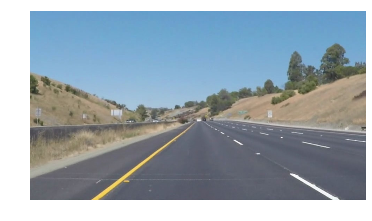

In [4]:
showImage(img_color)

(-0.5, 959.5, 539.5, -0.5)

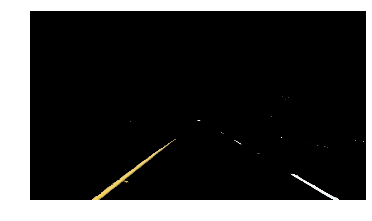

In [5]:
# Create mask for Yellow and White
lower_yellow = np.array([20, 100, 100], dtype=np.uint8)
upper_yellow = np.array([30, 255, 255], dtype=np.uint8)

lower_white = np.array([0, 0, 230], dtype=np.uint8)
upper_white = np.array([255, 20, 255], dtype=np.uint8)

yellow_mask = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
white_mask = cv2.inRange(img_hsv, lower_white, upper_white)

mask = cv2.bitwise_or(white_mask, yellow_mask)
image_masked = cv2.bitwise_or(img_color, img_color, mask=mask)

showImage(image_masked)
plt.axis("off")

(540, 960, 3)


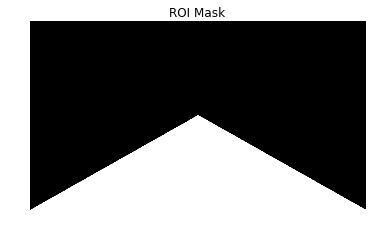

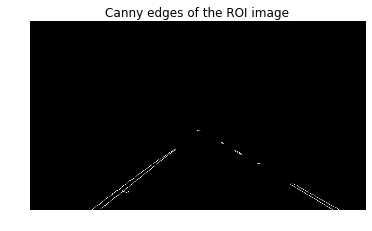

In [72]:
# Canny Edge detection
blur_masked = cv2.GaussianBlur(image_masked, (3,3), 0)
x_len, y_len, _= img_hsv.shape
canny_img = cv2.Canny(blur_masked, threshold1=50, threshold2=255, apertureSize=3)
plt.imshow(canny_img)

print(img_color.shape)
# Get Mask to extract region of interest from the canny image

vertices = np.array([[(0,im_height),(im_width/2, im_height/2), (im_width/2, im_height/2), (im_width,im_height)]], dtype=np.int32)
# vertices = np.array([[(im_width/2, im_height),(im_width/2, im_height/2), (im_width/2, im_height/2), (im_width,im_height)]], dtype=np.int32)
roi_mask = extractROI(canny_img, vertices)
roi_image = cv2.bitwise_and(canny_img, roi_mask)

plt.imshow(roi_mask, cmap='gray')
plt.axis('off')
plt.title('ROI Mask')
plt.show()
plt.imshow(roi_image, cmap='gray')
plt.axis('off')
plt.title('Canny edges of the ROI image')
plt.show()



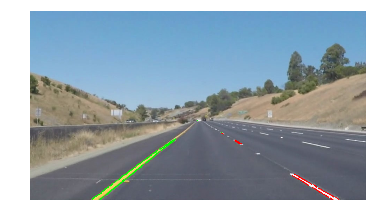

In [73]:
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(roi_image,3,np.pi/180,20,minLineLength)
# color = [(255, 255, 255), (0, 255, 255), (0, 0, 255), (255, 0, 0), (0, 255, 0)]

# If slope negative, then the lane is on the left side(marked in Green). 
# If the slope is positive, then the lane is on the right side(marked in Red)
# As we can see from the image below, there is a clear trend in lines but there are 
# many small lines. Ideally we need a single line instead of many small lines
img_intermediate = img_color.copy()
left_x = []
left_y = []
right_x = []
right_y = []
for x in range(0, len(lines)):
    for x1, y1, x2, y2 in lines[x]:
        if(x2 -x1) != 0:
            slope = (y2 - y1) / (x2 - x1) 
            if np.fabs(slope) < 0.2:
                continue
            elif slope < 0 : # left lane, green is left
                cv2.line(img_intermediate,(x1,y1),(x2,y2),(0,255,0),2)
                left_x.extend([x1, x2])
                left_y.extend([y1, y2])
            elif slope > 0:  # right lane, red is right, it rhymes ;)
                right_x.extend([x1, x2])
                right_y.extend([y1, y2])
                cv2.line(img_intermediate,(x1,y1),(x2,y2),(0,0,255),2)
        
showImage(img_intermediate)

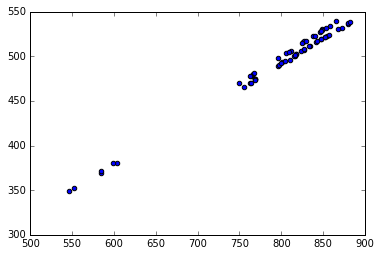

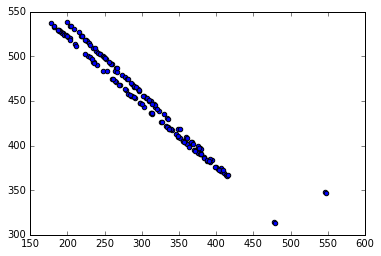

Right lane polynomial : 
1.721 x - 51.7
Left lane polynomial : 
-1.348 x + 910.4


In [77]:
# let's plot the right x and y coordinates as a scatter plot.
plt.scatter(right_x, right_y)
plt.show()
plt.scatter(left_x, left_y)
plt.show()
# To obtain a single line , we can apply linear regression to fit a line to the points. 
# We start by fitting a polynomial of degree one and we get a polynomial for right lane
deg_1_poly = np.polyfit(right_y, right_x, deg=1)
right_lane_polynomial = np.poly1d(deg_1_poly)
print('Right lane polynomial :' + str(right_lane_polynomial))

deg_1_poly = np.polyfit(left_y, left_x, deg=1)
left_lane_polynomial = np.poly1d(deg_1_poly)
print('Left lane polynomial :' + str(left_lane_polynomial))


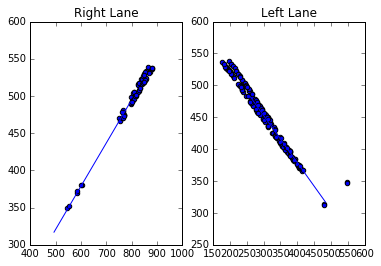

In [91]:
# Get a single line from the polynomial. Since the line cannot extend from bottom to the top of the image, 
# let us limit the line to region of interest
min_y = int(img_final.shape[0]/1.7)
max_y = int(img_final.shape[0] )
right_x_start = int(right_lane_polynomial(max_y))
right_x_end = int(right_lane_polynomial(min_y))

left_x_start = int(left_lane_polynomial(max_y))
left_x_end = int(left_lane_polynomial(min_y))

# let's plot the right x and y coordinates as a scatter plot and also plot the regression line 
reg_x = np.arange(min_y, right_x_end)
reg_y = right_lane_polynomial(reg_x)
p1 = plt.subplot(121)
p1.plot(reg_y, reg_x)
p1.scatter(right_x, right_y)
p1.title.set_text("Right Lane")



reg_x = np.arange(min_y, left_x_end)
reg_y = left_lane_polynomial(reg_x)
p2 = plt.subplot(122)
p2.plot(reg_y, reg_x)
p2.scatter(left_x, left_y)
p2.title.set_text("Left Lane")

plt.show()



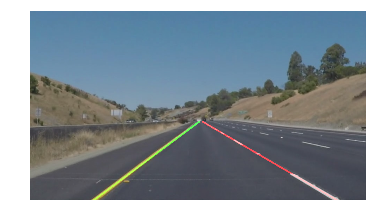

In [87]:
# [left_x_start, max_y, left_x_end, min_y],
#             [right_x_start, max_y, right_x_end, min_y],
img_final = img_color.copy()
# cv2.line(img_final, (right_x_start, max_y), (right_x_end, min_y), (0, 255,0), 4)
# cv2.line(img_final, (left_x_start, max_y), (left_x_end, min_y), (0, 0,255), 4)
# showImage(img_final)

just_line = np.zeros(img_final.shape, dtype=np.uint8);
cv2.line(just_line, (right_x_start, max_y), (right_x_end, min_y), (0, 0,255), 4)
cv2.line(just_line, (left_x_start, max_y), (left_x_end, min_y), (0, 255,0), 4)

img_final = cv2.addWeighted(img_final, 0.8, just_line, 1, 0);
showImage(img_final)